# Icentia11k-02-find-sequences.ipynb
Analyze the Icentia11k Single Lead Continuous Raw Electrocardiogram Dataset and identify rhythm sequences for training a neural network model.  
Identified rhythm sequences are written to a CSV file.  
The CSV file is used by another notebook to download the rhythm sequences.  
See https://physionet.org/content/icentia11k-continuous-ecg/1.0/

In [1]:
# Environment setup.
import os
import re
import sys
import wfdb
from wfdb.io._url import NetFileNotFoundError

from time import localtime, strftime

import icentia11k as ic
import icentia11k_wfdb_utils as wfu

min_seq_sec     = 30 # Minimum sequence length in seconds
min_seq_length  = min_seq_sec * ic.FS_HZ  # Minimum sequence length in samples

In [2]:
# Function to plot annotated ECG data.
def plot_ecg(patient_id, segment_id, *, start=0, length=2500, stream=False):
    ann = wfu.read_annotation(patient_id, segment_id, start=start, length=length, stream=stream)
    ecg = wfu.read_ecg(patient_id, segment_id, start=start, length=length, stream=stream)
    wfdb.plot_wfdb(ecg, ann, plot_sym=True, figsize=(15,4))

In [3]:
# Function to create a rhythms CSV file name from a patient ID.
def get_rhythms_filename(patient_id):
    i_patient_id = int(patient_id)  # Make sure we have an integer
    mod = i_patient_id % 100
    first = i_patient_id - mod
    last = first + 99
    basename = 'rhythms_p{:05d}_p{:05d}.csv'.format(first, last)
    filename = os.path.join(ic.LOCAL_DATA_PATH, basename)
    #print(filename)
    return filename

# Function to append a list of annotated rhythm sequences to the rhythms CSV file.
def add_rhythms_to_file(rhythms_list, patient_id, segment_id):
    rhythms_filename = get_rhythms_filename(patient_id)
    with open(rhythms_filename, 'a') as f:
        for (rhythm_type, start, length) in rhythms_list:
            csv_record = 'p{:05d},s{:02d},{},{},{}\n'.format(patient_id, segment_id, rhythm_type, start, length)
            f.write(csv_record)
    f.close()

In [4]:
# Function to get annotated rhythm sequences bound by parentheses.
# Returns a list of (type, start, length) tuples.
def get_defined_rhythms(ann):
    rhythm_list = []
    if ann is None:
        return rhythm_list
    rhythm_start = -1
    rhythm_end = -1
    rhythm_type = '?'
    in_rhythm = False
    for i in range(len(ann.aux_note)):
        if ann.aux_note[i].startswith('('):
            rhythm_start = ann.sample[i]
            rhythm_type = ann.aux_note[i][1:]
            in_rhythm = True
        elif ann.aux_note[i].startswith(')'):
            if in_rhythm:
                rhythm_end = ann.sample[i]
                rhythm_length = rhythm_end - rhythm_start + 1
                if (rhythm_length >= min_seq_length):
                    rhythm_list.append((rhythm_type, rhythm_start, rhythm_length))
                in_rhythm = False
    return rhythm_list

In [5]:
# Function to get undefined rhythms (labeled with Q).
# Returns a list of (type, start, length) tuples.
def get_undefined_rhythms(ann):
    rhythm_list = []
    if ann is None:
        return rhythm_list
    min_q_count = 5
    q_count = 0
    q_start = -1
    q_end = -1
    for i in range(len(ann.symbol)):
        if (ann.symbol[i] == 'Q'):
            if (q_count == 0):
                q_start = ann.sample[i]
            q_count += 1
        else:
            if (q_count > 0):
                q_end = ann.sample[i-1]
                if (q_count >= min_q_count):
                    q_length = q_end - q_start + 1
                    if (q_length >= min_seq_length):
                        rhythm_list.append(('Q', q_start, q_length))
            q_count = 0
    return rhythm_list

In [6]:
# Main function to get annotated rhythms.
# Specify a starting patient ID and the number of IDs to process.
# This allows us to work in batches.
# Annotated rhythm sequence descriptions are written to a rhythms_*.csv file in the associated data directory.
def get_all_rhythms(start_id, num_ids, stream=False, start_segment=0):
    start = True
    fnf_tries = 3
    for patient_id in range(start_id, start_id+num_ids):
    
        # Progress indicator.
        if start or (int(patient_id) % 10 == 0):
            start = False
            print('{} Patient ID {}'.format(ic.timestamp(), patient_id))
    
        fnf_count = 0 # File not found count
        
        for segment_id in range(start_segment, ic.MAX_SEGMENTS):
            try:
                # Get the annotation for the patient ID and segment ID.
                ann = wfu.read_annotation(patient_id, segment_id, stream=stream)
                fnf_count = 0 # Found an annotation file if we made it this far.
            
                # Get defined rhythms bound by parentheses.
                rhythms_list = get_defined_rhythms(ann)
                if (len(rhythms_list) > 0):
                    add_rhythms_to_file(rhythms_list, patient_id, segment_id)
            
                # Get undefined rhythms.
                rhythms_list = get_undefined_rhythms(ann)
                if (len(rhythms_list) > 0):
                    add_rhythms_to_file(rhythms_list, patient_id, segment_id)
            
            except NetFileNotFoundError:
                fnf_count += 1
                if (fnf_count >= fnf_tries):
                    print('Patient ID {} stopping at segment {}'.format(patient_id, segment_id-fnf_count+1))
                    break
                else:
                    continue
                    
            except KeyboardInterrupt:
                print('Processing interrupted')
                return
            
    # Done.
    print('{} Patient ID {} complete.'.format(ic.timestamp(), patient_id))

### Get rhythm sequences from the dataset   
Rhythm sequence information is written to a CSV file in the associated data directory.

In [7]:
# Get rhythm sequences from the dataset.
# Write descriptive data to a rhythms_*.csv file in the associated data directory, one file per 100 patient IDs.
# Specify a starting patient ID and the number of IDs to process.
# This allows us to work in batches.
start_id = 10322
num_ids = 1
get_all_rhythms(start_id, num_ids, stream=True)

2023-08-09 20:13:48 Patient ID 10322
2023-08-09 20:13:58 Patient ID 10322 complete.


### Plot a representative sequence

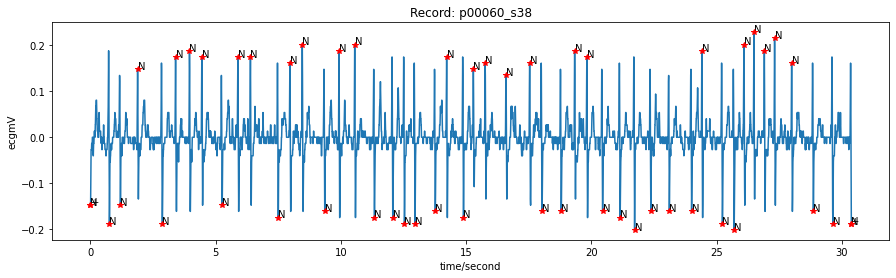

In [8]:
# Plot a representative sequence.
#plot_ecg(patient_id=10, segment_id=22, start=788665, length=2160, stream=True)     # AFL
#plot_ecg(patient_id=1111, segment_id=49, start=490100, length=851, stream=True)
#plot_ecg(patient_id=1108, segment_id=38, start=721588, length=10917, stream=True)
plot_ecg(patient_id=60, segment_id=38, start=79770, length=7596, stream=True)       # NSR

### Analyze the rhythm sequence files
Determine how many examples we have based on span and stride.

In [9]:
# Function to return the rhythm sequence stats for a single file.
def get_sequence_file_stats(file, span_sec, stride_sec):
    sequences_n = 0
    examples_n = 0
    sequences_afib = 0
    examples_afib = 0
    sequences_afl = 0
    examples_afl = 0
    sequences_q = 0
    examples_q = 0
    
    span_samps = span_sec * ic.FS_HZ
    stride_samps = stride_sec * ic.FS_HZ
    
    with open(file, 'r') as f:
        last_pid = -1
        last_sid = 0
        for line in f:
            (pid, sid, rtype, start, length) = line.strip().split(',')
            
            # Used to print patient IDs that may have data in later segments.
            #i_pid = int(pid[1:])
            #i_sid = int(sid[1:])
            #if (i_pid != last_pid) and (last_pid >= 0):
            #    if (last_sid < 15):
            #        print('Patient {} last segment {}'.format(last_pid, last_sid))
            #last_sid = i_sid
            #last_pid = i_pid
            
            i_length = int(length)
            if (i_length >= span_samps):
                examples = 1 + ((i_length - span_samps) // stride_samps)
                if (rtype == 'N'): 
                    sequences_n += 1
                    examples_n += examples
                elif (rtype == 'AFIB'): 
                    sequences_afib += 1
                    examples_afib += examples
                elif (rtype == 'AFL'): 
                    sequences_afl += 1
                    examples_afl += examples
                elif (rtype == 'Q'): 
                    sequences_q += 1
                    examples_q += examples
    f.close()
    return (sequences_n, examples_n, 
            sequences_afib, examples_afib, 
            sequences_afl, examples_afl, 
            sequences_q, examples_q)

In [10]:
# Function to compute and print the rhythm sequence stats for all files.
def get_sequence_stats(span_sec, stride_sec, verbose=False):
    rhythms_file_pat = re.compile(ic.RHYTHMS_FILE_RE)
    total_files = 0
    total_n = 0
    total_afib = 0
    total_afl = 0
    total_q = 0
    for (dirpath, dirs, files) in os.walk(ic.LOCAL_DATA_PATH):
        for file in files:
            if rhythms_file_pat.match(file):
                total_files += 1
                (sequences_n, examples_n, 
                 sequences_afib, examples_afib, 
                 sequences_afl, examples_afl, 
                 sequences_q, examples_q) = get_sequence_file_stats(os.path.join(dirpath, file), span_sec, stride_sec)
                total_n += examples_n
                total_afib += examples_afib
                total_afl += examples_afl
                total_q += examples_q
                if verbose:
                    print('{}:'.format(file))
                    print('  NSR:  {} sequences, {} examples'.format(sequences_n, examples_n))
                    print('  AFIB: {} sequences, {} examples'.format(sequences_afib, examples_afib))
                    print('  AFL:  {} sequences, {} examples'.format(sequences_afl, examples_afl))
                    print('  UNK:  {} sequences, {} examples'.format(sequences_q, examples_q))
    percent_factor = 100.0 / (total_n + total_afib + total_afl + total_q)
    print('Total patients:      {:8d}'.format(total_files * 100))  # Assume 100 patients per file
    print('Total NSR examples:  {:8d} ({:0.2f}%)'.format(total_n, total_n*percent_factor))
    print('Total AFIB examples: {:8d} ({:0.2f}%)'.format(total_afib, total_afib*percent_factor))
    print('Total AFL examples:  {:8d} ({:0.2f}%)'.format(total_afl, total_afl*percent_factor))
    print('Total UNK examples:  {:8d} ({:0.2f}%)'.format(total_q, total_q*percent_factor))
    return (total_n, total_afib, total_afl, total_q)

In [11]:
# Compute and print the number of rhythm sequences that meet the span and stride criteria.
seq_span_sec = 30    # Rhythm sequence span in seconds
seq_stride_sec = 30  # Rhythm sequence stride in seconds
(total_n, total_afib, total_afl, total_q) = get_sequence_stats(seq_span_sec, seq_stride_sec)
total_examples = min(total_n, total_afib, total_afl, total_q) * 4
print('Total evenly distributed examples: {}'.format(total_examples))

Total patients:         11100
Total NSR examples:  47252499 (80.46%)
Total AFIB examples:  2427006 (4.13%)
Total AFL examples:    826867 (1.41%)
Total UNK examples:   8220050 (14.00%)
Total evenly distributed examples: 3307468
